# 设置参数

In [30]:
# 初始化一些超参
minibatch_size = 64  # the number of instances in a batch ：一个batch的图片数量
nr_channel = 3 # the channels of image
image_shape = (32, 32) # the image shape (height, width)
nr_class = 10 # the number of classes
nr_epoch = 20 # the max epoch of training 控制整个数据集通过神经网络的次数
weight_decay = 1e-10 # a strength of regularization
test_interval = 5 # test in every ${test_interval} epochs
show_interval = 10 # print a message of training in every ${show_interval} minibatchs 

trainSize = 73257 # 73257->30000->10000
testSize = 26032 # 26032 constant

import os
import numpy as np
from scipy import io as scio
import cv2
import matplotlib.pyplot as plt
import pickle 
# %matplotlib

In [31]:
def colorInv(img): # colore inversion
    for k in range(3):
        for i in range(32):
            for j in range(32):
                flag = np.random.exponential(10, size=1)  # 产生1个满足指数分布的随机数
                if flag < 0.01:
                    img[i,j] = 255 - img[i,j]
    return img

def addsalt_pepper(img, SNR = 0.7):
    img_ = img.transpose(2,1,0)
    c, h, w = img_.shape
    mask = np.random.choice((0, 1, 2), size=(1, h, w), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    mask = np.repeat(mask, c, axis=0)     # 按channel 复制到 与img具有相同的shape
    img_[mask == 1] = 255    # pepper
    img_[mask == 2] = 0      # white
    return img_.transpose(2,1,0)



# 构建TF迭代器
- reduce the amount of images labelled with'8' '9' and '0' to 500 and get Dataset A

  cnt = [500, 13861, 10585, 8497, 7458, 6882, 5727, 5595, 500, 500]

- reduce the amount of images labelled with '6', '7', '8','9' and '0' to 1000 and get Dataset B

  cnt = [1000, 13861, 10585, 8497, 7458, 6882, 1000, 1000, 1000, 1000]

- reduce the amount of images labelled with '1','2','3','4'and '5' to 6000 and get Dataset C

  cnt = [4948, 6000, 6000, 6000, 6000, 6000, 5727, 5595, 5045, 4659]

In [35]:


class Dataset():
    dsPath = './data' # path for saving dataset
    dsMeta = {
        #'train':('./obj/train_color.obj',trainSize),
        'train':('./obj/train_sp.obj',trainSize),
        # 'train': ([os.path.join(dsPath,'train_32x32.mat')],trainSize),
        'test':([os.path.join(dsPath,'test_32x32.mat')],testSize),
    }
    
    def __init__(self,dsName):
        self.files, self.instances = self.dsMeta[dsName] # 定义files 和 instance 成员
    
    def load(self):
        datas_list, labels_list = [], []
        print(self.files)
        if self.files == './obj/train_sp.obj':
            f = open(self.files,'rb')
            data = pickle.load(f)
            data['X'] = data['X'].transpose(0,3,1,2)
            self.samples = {
                'X':data['X'],
                'Y':data['y'],
            }
        else :
            for f in self.files:
                samples = scio.loadmat(f) # 使用load函数解压.mat文件
                datas_list.append(samples['X'])
                labels_list.append(samples['y'])
                # print(samples['X'].shape,samples['X'])
                # break
            self.samples = {
                'X': np.concatenate(datas_list, axis=3), # datas
                'Y': np.concatenate(labels_list, axis=0), # labels
            }
        return self
        
    def instance_generator(self): # 产生一张图片
        '''a generator to yield a sample'''
        cnt0,cnt8,cnt9 = 0,0,0 # dist-A 500
        cnt6,cnt7,cnt8,cnt9=0,0,0,0 # dist-B 1000
        cnt1, cnt2, cnt3, cnt4, cnt5 =0,0,0,0,0 # dist-C 6000
        for i in range(self.instances):
            img = self.samples['X'][:, :, :, i]
            label = self.samples['Y'][i, :][0]
            '''"控制数据的分布"
            if label == 10:
                label = 0 # 把标签为10改为标签为0
                cnt0 += 1
            elif label == 6:
                cnt6 += 1
            elif label == 7:
                cnt7 += 1
            elif label == 8:
                cnt8 += 1
            elif label == 9:
                cnt9 += 1
            if (cnt0>=1000 and label==0) or (cnt6 >= 1000 and label==6) or (cnt7 >=1000 and label==7) or (cnt8 >= 1000 and label==8) or (cnt9 >=1000 and label==9):
                continue'''
            img = cv2.resize(img, image_shape) # 图片统一乘32*32
            yield img.astype(np.float32), np.array(label, dtype=np.int32) # 解析出一张图片和label
            
    @property
    def instances_per_epoch(self):
        return 25600 # set for a fast experiment
        #return self.instances
    
    @property
    def minibatchs_per_epoch(self):
        return 200 # set for a fast experimetn
        #return self.instances // minibatch_size   

import pickle

train = Dataset('train').load()
train_sp = []

cnt = 0 
for i in range(train.instances):
    cnt+=1
    print(cnt)
    img = train.samples['X'][:,:,:,10]
    img = addsalt_pepper(img) # 颜色反转
    train_sp.append(img)
    
train_sp = np.array(train_sp)
train_sp = train_color.transpose(1,2,3,0)
print(train_color.shape)

f = open('obj/train_sp.obj','wb')
train_sp = {
    'X':train_sp,
    'y':train.samples['Y'],
}
pickle.dump(train_sp,f)

f = open('./obj/train_sp.obj','rb')
print(pickle.load(f))

# Put Label Onto IMG

In [36]:


def showGrid():
    print("Loading...")
    ds = Dataset('train').load()
    ds_gen = ds.instance_generator()
    print("Finish")


    imggrid = [] # (25*32*32*3)
    for i in range(25):
        img,label = next(ds_gen)
        cv2.putText(img,str(label),(0,32),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,255),2)
        imggrid.append(img)

    print(imggrid[0].shape)
    print(img.shape)
    imggrid = np.array(imggrid).reshape((5,5,img.shape[0],img.shape[1],img.shape[2])) # 5*5*32*32*3
    imggrid = imggrid.transpose((0,2,1,3,4)).reshape((5*img.shape[0],5*img.shape[1],3)) # 
    imggrid = cv2.cvtColor(imggrid.astype("uint8"),cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(imggrid)
    plt.show()
    
# showGrid()

# statistic

In [37]:
def statistic():
    ds = Dataset('train').load()
    ds_gen = ds.instance_generator()
    labels = np.zeros((10,),dtype=np.int32)
    cnt = 0
    for img,label in ds_gen:
        labels[label % 10] += 1
    print(labels)
    print(np.sum(labels))
    # img = train.samples['X'][:,:,:,10]
    # img = addsalt_pepper(img) # 颜色反转
    # train_sp.append(img)
statistic()

./obj/train_sp.obj
[ 4948 13861 10585  8497  7458  6882  5727  5595  5045  4659]
73257


# DEEP NET BUILD
控制正则化方法
池化方法

In [38]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib



class Model():
    '''a class for building a compute graph'''
    
    def __init__(self):
        # set the initializer of conv_weight and conv_bias
        self.weight_init = tf_contrib.layers.variance_scaling_initializer(factor=1.0,
                                mode='FAN_IN', uniform=False)
        self.bias_init = tf.zeros_initializer()
        # set l2 regularizer
        self.reg = tf_contrib.layers.l2_regularizer(weight_decay)
        # set l1 regularizer
        #self.reg = tf_contrib.layers.l1_regularizer(weight_decay)

    def _conv_layer(self, name, inp, kernel_shape, stride, padding='SAME',is_training=False):
        '''a conv layer = conv + bn + relu'''
        
        with tf.variable_scope(name) as scope:
            conv_filter = tf.get_variable(name='filter', shape=kernel_shape,
                                          initializer=self.weight_init, regularizer=self.reg)
            conv_bias = tf.get_variable(name='bias', shape=kernel_shape[-1],
                                        initializer=self.bias_init)
            x = tf.nn.conv2d(inp, conv_filter, strides=[1, stride, stride, 1],
                             padding=padding, data_format='NHWC')
            x = tf.nn.bias_add(x, conv_bias, data_format='NHWC')
            x = tf.layers.batch_normalization(x, axis=3, training=is_training)
            x = tf.nn.relu(x)
        return x
    
    def _pool_layer(self, name, inp, ksize, stride, padding='SAME', mode='MAX'):
        '''a pool layer which only supports avg_pooling and max_pooling(default)'''
        
        assert mode in ['MAX', 'AVG'], 'the mode of pool must be MAX or AVG'
        if mode == 'MAX':
            x = tf.nn.max_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        elif mode == 'AVG':
            x = tf.nn.avg_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        return x

    def _fc_layer(self, name, inp, units, dropout=0.5):
        '''a full connect layer'''
        
        with tf.variable_scope(name) as scope:
            shape = inp.get_shape().as_list() # get the shape of input
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(inp, [-1, dim]) # flatten : 将数据压平：多维的数据归一化
            if dropout > 0: # if with dropout
                x = tf.nn.dropout(x, keep_prob=dropout, name='dropout')
            x = tf.layers.dense(x, units, kernel_initializer=self.weight_init,
                                bias_initializer=self.bias_init, kernel_regularizer=self.reg)
        return x

    def build(self):
        # set inputs
        data = tf.placeholder(tf.float32, shape=(None,)+image_shape+(nr_channel,),
                              name='data')
        label = tf.placeholder(tf.int32, shape=(None,), name='label')
        label_onehot = tf.one_hot(label, nr_class, dtype=tf.int32) 
        is_training = tf.placeholder(tf.bool, name='is_training') # a flag of bn（）
        
        # conv1
        x = self._conv_layer(name='conv1', inp=data,
                             kernel_shape=[3, 3, nr_channel, 16], stride=1,
                             is_training=is_training) # Nx32x32x32
        x = self._pool_layer(name='pool1', inp=x, ksize=2, stride=2, mode='MAX') # Nx16x16x16

        # conv2
        x = self._conv_layer(name='conv2a', inp=x, kernel_shape=[3, 3, 16, 32],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv2b', inp=x, kernel_shape=[3, 3, 32, 32],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool2', inp=x, ksize=2, stride=2, mode='MAX') # Nx8x8x32
        
        # conv3
        x = self._conv_layer(name='conv3a', inp=x, kernel_shape=[3, 3, 32, 64],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv3b', inp=x, kernel_shape=[3, 3, 64, 64],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool3', inp=x, ksize=2, stride=2, mode='MAX') # Nx4x4x64

        # conv4
        x = self._conv_layer(name='conv4a', inp=x, kernel_shape=[3, 3, 64, 128],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv4b', inp=x, kernel_shape=[3, 3, 128, 128],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool4', inp=x, ksize=4, stride=4, mode='AVG') # Nx1x1x128
        
        # fc
        logits = self._fc_layer(name='fc1', inp=x, units=nr_class, dropout=0)
        
        placeholders = {
            'data': data,
            'label': label,
            'is_training': is_training,
        }
        return placeholders, label_onehot, logits


# Set Loss Function

In [39]:
tf.reset_default_graph() # 一定要设置TF的默认图
def get_dataset_batch(ds_name):
    '''get a batch generator of dataset'''
    dataset = Dataset(ds_name) # 得到数据集
    ds_gnr = dataset.load().instance_generator # 加载数据
    ds = tf.data.Dataset.from_generator(ds_gnr, output_types=(tf.float32, tf.int32),) #创建一个迭代器
    if ds_name == 'train':
        ds = ds.shuffle(dataset.instances_per_epoch) #在数据集中每个epoch都进行随机洗牌
        ds = ds.repeat(nr_epoch) #设置最高重复使用的次数
    elif ds_name == 'test':
        "测试集不用shuffle"
        ds = ds.repeat(nr_epoch // test_interval)
    ds = ds.batch(minibatch_size, drop_remainder=True) # 按照指定的大小batch 大小为64
    ds_iter = ds.make_one_shot_iterator() # 创建一个迭代器：产生一次训练真实图片数据
    sample_gnr = ds_iter.get_next() # 获取下一组数据
    return sample_gnr, dataset

# load datasets
train_batch_gnr, train_set = get_dataset_batch(ds_name='train')
test_batch_gnr, test_set = get_dataset_batch(ds_name='test')


# build a compute graph
network = Model() 
placeholders, label_onehot, logits = network.build() # 数据流动

# """softmax
preds = tf.nn.softmax(logits) # 最后一层的激活函数


"""non-negative-max
relu_logits = tf.nn.relu(logits)
preds = relu_logits / tf.reduce_sum((relu_logits),axis=1,keepdims = True)"""

"""square logits
square_logits = logits*logits
preds = square_logits / tf.reduce_sum(square_logits,axis=1,keepdims = True)"""

"""abs-max
abs_logits = tf.abs(logits)
preds = abs_logits / tf.reduce_sum(abs_logits, axis=1, keepdims=True)"""

"""plus one-max"
plus_one_abs_logits = tf.abs(logits) + 1.0
preds = plus_one_abs_logits / tf.reduce_sum(plus_one_abs_logits, axis=1, keepdims=True)"""


loss_reg = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)) # 正则化
loss = tf.losses.softmax_cross_entropy(label_onehot, logits) + loss_reg # 计算损失 + 正则化系数
# loss = tf.losses.mean_squared_error(label_onehot, logits) + loss_reg

# set a performance metric
correct_pred = tf.equal(tf.cast(tf.argmax(preds, 1), dtype=tf.int32),
                        tf.cast(tf.argmax(label_onehot, 1), dtype=tf.int32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# learn rate config
global_steps = tf.Variable(0, trainable=False) # a cnt to record the num of minibatchs
boundaries = [train_set.minibatchs_per_epoch*15, train_set.minibatchs_per_epoch*40] 
values = [0.01, 0.001, 0.0005]
lr = tf.train.piecewise_constant(global_steps, boundaries, values)

opt = tf.train.AdamOptimizer(lr) # use adam as optimizer

# in order to update BN in every iter, a trick in tf
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train = opt.minimize(loss)

./obj/train_sp.obj


W0308 19:29:28.257074   424 deprecation.py:323] From D:\Anoconda\new\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0308 19:29:28.281011   424 deprecation.py:323] From <ipython-input-39-d400a89c5fab>:14: D

['./data\\test_32x32.mat']


W0308 19:29:28.878410   424 deprecation.py:323] From <ipython-input-38-5d798daefdc3>:30: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0308 19:29:29.282374   424 deprecation.py:323] From <ipython-input-38-5d798daefdc3>:58: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0308 19:29:29.504775   424 deprecation.py:323] From D:\Anoconda\new\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, whi

In [40]:
tf.set_random_seed(12345)
global_cnt = 0

testLoss, testAcc = [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(nr_epoch): # 整个数据集通过网络的次数
        for _ in range(train_set.minibatchs_per_epoch):#  迭代200次
            global_cnt += 1
            try:
                images,labels = sess.run(train_batch_gnr) #每次使用64张图片
            except tf.errors.OutOfRangeError:
                break
            fd = {
                placeholders['data']:images,
                placeholders['label']:labels,
                global_steps: global_cnt,
                placeholders['is_training']:True,
            }
            _, loss_v, acc_v,lr_v = sess.run([train,loss,accuracy,lr],feed_dict = fd)
            
            if(global_cnt % show_interval == 0):
                print(
                "e:{},{}/{}".format(e, global_cnt % train_set.minibatchs_per_epoch,
                                   train_set.minibatchs_per_epoch),
                "loss:{:.3f}".format(loss_v),
                "acc:{:.3f}".format(acc_v),
                "lr:{:.3f}".format(lr_v))
                
        if e % test_interval == 0: # test_interval = 5
            loss_sum, acc_sum = 0, 0
            for i in range(test_set.minibatchs_per_epoch):# test_per_epoch
                images,labels = sess.run(test_batch_gnr)
                fd = {
                    placeholders['data']:images,
                    placeholders['label']:labels,
                    global_steps: global_cnt,
                    placeholders['is_training']:False,
                }
                preds_v, loss_v, acc_v = sess.run([preds,loss,accuracy],feed_dict=fd)
                testLoss.append(loss_v)
                testAcc.append(acc_v)
                loss_sum += loss_v
                acc_sum += acc_v
        print("\n**************Validation results****************")
        print('loss_avg: {:.3f}'.format(loss_sum / test_set.minibatchs_per_epoch),
              'accuracy_avg: {:.3f}'.format(acc_sum / test_set.minibatchs_per_epoch))
        print("************************************************\n") 
print('trainning is done')   

e:0,10/200 loss:2.091 acc:0.141 lr:0.010
e:0,20/200 loss:2.044 acc:0.109 lr:0.010
e:0,30/200 loss:1.953 acc:0.078 lr:0.010
e:0,40/200 loss:1.998 acc:0.125 lr:0.010
e:0,50/200 loss:2.083 acc:0.109 lr:0.010
e:0,60/200 loss:2.114 acc:0.156 lr:0.010
e:0,70/200 loss:1.957 acc:0.312 lr:0.010
e:0,80/200 loss:1.989 acc:0.266 lr:0.010
e:0,90/200 loss:1.985 acc:0.188 lr:0.010
e:0,100/200 loss:2.070 acc:0.141 lr:0.010
e:0,110/200 loss:2.053 acc:0.172 lr:0.010
e:0,120/200 loss:2.082 acc:0.094 lr:0.010
e:0,130/200 loss:2.180 acc:0.250 lr:0.010
e:0,140/200 loss:1.974 acc:0.109 lr:0.010
e:0,150/200 loss:2.076 acc:0.094 lr:0.010
e:0,160/200 loss:2.131 acc:0.125 lr:0.010
e:0,170/200 loss:1.919 acc:0.172 lr:0.010
e:0,180/200 loss:2.133 acc:0.125 lr:0.010
e:0,190/200 loss:2.083 acc:0.203 lr:0.010
e:0,0/200 loss:2.250 acc:0.172 lr:0.010

**************Validation results****************
loss_avg: 2.149 accuracy_avg: 0.111
************************************************

e:1,10/200 loss:2.120 acc:0.172 lr:

e:8,120/200 loss:11.143 acc:0.094 lr:0.010
e:8,130/200 loss:12.093 acc:0.078 lr:0.010
e:8,140/200 loss:13.916 acc:0.109 lr:0.010
e:8,150/200 loss:17.635 acc:0.109 lr:0.010
e:8,160/200 loss:15.645 acc:0.078 lr:0.010
e:8,170/200 loss:11.112 acc:0.031 lr:0.010
e:8,180/200 loss:5.144 acc:0.172 lr:0.010
e:8,190/200 loss:13.650 acc:0.156 lr:0.010
e:8,0/200 loss:16.787 acc:0.250 lr:0.010

**************Validation results****************
loss_avg: 8.538 accuracy_avg: 0.075
************************************************

e:9,10/200 loss:12.357 acc:0.047 lr:0.010
e:9,20/200 loss:16.073 acc:0.234 lr:0.010
e:9,30/200 loss:16.214 acc:0.172 lr:0.010
e:9,40/200 loss:7.223 acc:0.094 lr:0.010
e:9,50/200 loss:11.849 acc:0.188 lr:0.010
e:9,60/200 loss:8.628 acc:0.203 lr:0.010
e:9,70/200 loss:9.113 acc:0.172 lr:0.010
e:9,80/200 loss:11.247 acc:0.031 lr:0.010
e:9,90/200 loss:14.804 acc:0.203 lr:0.010
e:9,100/200 loss:15.597 acc:0.047 lr:0.010
e:9,110/200 loss:12.580 acc:0.125 lr:0.010
e:9,120/200 loss:9.

e:16,180/200 loss:2.175 acc:0.188 lr:0.001
e:16,190/200 loss:2.013 acc:0.188 lr:0.001
e:16,0/200 loss:2.052 acc:0.125 lr:0.001

**************Validation results****************
loss_avg: 16.227 accuracy_avg: 0.157
************************************************

e:17,10/200 loss:2.130 acc:0.078 lr:0.001
e:17,20/200 loss:1.913 acc:0.172 lr:0.001
e:17,30/200 loss:2.095 acc:0.156 lr:0.001
e:17,40/200 loss:2.205 acc:0.172 lr:0.001
e:17,50/200 loss:2.205 acc:0.125 lr:0.001
e:17,60/200 loss:2.046 acc:0.172 lr:0.001
e:17,70/200 loss:2.060 acc:0.078 lr:0.001
e:17,80/200 loss:2.155 acc:0.047 lr:0.001
e:17,90/200 loss:2.007 acc:0.156 lr:0.001
e:17,100/200 loss:2.167 acc:0.094 lr:0.001
e:17,110/200 loss:2.101 acc:0.172 lr:0.001
e:17,120/200 loss:2.050 acc:0.125 lr:0.001
e:17,130/200 loss:2.031 acc:0.156 lr:0.001
e:17,140/200 loss:2.160 acc:0.109 lr:0.001
e:17,150/200 loss:2.142 acc:0.188 lr:0.001
e:17,160/200 loss:2.249 acc:0.188 lr:0.001
e:17,170/200 loss:2.106 acc:0.062 lr:0.001
e:17,180/200 l

In [41]:

f = open('./add_saltpep.obj','wb')
pickle.dump(testLoss,f)
pickle.dump(testAcc,f)
f.close()
print("dump sucess")


dump sucess


800
800


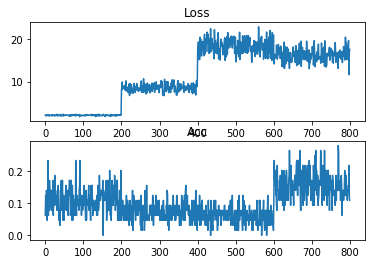

In [42]:
f = open('./add_saltpep.obj','rb')
testLoss = pickle.load(f)
testAcc = pickle.load(f)

print(len(testLoss))
print(len(testAcc))

plt.figure()
plt.subplot(211)
plt.plot(range(800),testLoss)
plt.title('Loss')
plt.subplot(212)
plt.plot(range(800),testAcc)
plt.title('Acc')

plt.show()